<a href="https://colab.research.google.com/github/choderalab/rumm/blob/master/rumm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

### clone the repo

In [1]:
! rm -rf *
! git clone https://github.com/choderalab/rumm.git

Cloning into 'rumm'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 88 (delta 46), reused 59 (delta 26), pack-reused 0
Unpacking objects: 100% (88/88), done.


### imports

In [0]:
# imports
import tensorflow as tf
try:
    tf.enable_eager_execution()
except:
    pass
import numpy as np
import pandas as pd
import sys
sys.path.append('rumm/rumm')
import lang
import nets
import box


### get the dataset from MoleculeNet

In [3]:
! wget https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/ESOL.zip
! unzip ESOL.zip

--2018-12-08 23:16:54--  https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/molnet_publish/ESOL.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.161
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32317 (32K) [application/zip]
Saving to: ‘ESOL.zip’

ESOL.zip            100%[===================>]  31.56K  --.-KB/s    in 0.1s    

2018-12-08 23:16:55 (233 KB/s) - ‘ESOL.zip’ saved [32317/32317]

Archive:  ESOL.zip
  inflating: delaney-processed.csv   
  inflating: ESOL_README             


### load datasets

In [0]:
df = pd.read_csv('delaney-processed.csv')
n_samples = df.shape[0]
df_sampled = df.sample(n_samples)

# use 80-20 split for training and test data
n_training = int(n_samples * 0.8)
y_tr = np.array(df_sampled.values[:n_training, 1], dtype=np.float32)
x_tr = df_sampled.values[:n_training, -1]
y_te = np.array(df_sampled.values[n_training:, 1], dtype=np.float32)
x_te = df_sampled.values[n_training:, -1]

lang_obj = lang.Lang(x_tr)
vocab_size = len(lang_obj.idx2ch)
x_tensor = lang.preprocessing(x_tr, lang_obj)
y_tensor = tf.convert_to_tensor(np.transpose([y_tr.flatten()]))

In [0]:
x_tensor_te = lang.preprocessing(x_te, lang_obj)
y_tensor_te = tf.convert_to_tensor(np.transpose([y_te.flatten()]))

## Construct the Model

### initialize the models

In [0]:
enc_f = nets.Encoder(vocab_size=vocab_size, reverse=False)
enc_b = nets.Encoder(vocab_size=vocab_size, reverse=True)
attention = nets.BidirectionalAttention(128)
fcuk = nets.FullyConnectedUnits([64, 0.25, 'tanh', 64, 0.10, 'tanh', 32, 1])

### define flow *function*

In [0]:
def flow(xs, models):
    enc_f, enc_b, attention, fcuk = models
    eo_f, h_f = enc_f(xs)
    eo_b, h_b = enc_b(xs)
    attention_weights = attention(eo_f, eo_b, h_f, h_b)
    ys = fcuk(attention_weights)
    return ys

### define the wrapper object

In [0]:
black_box = box.Box(flow, [enc_f, enc_b, attention, fcuk], 10, 32)

In [9]:
black_box.train(x_tensor, y_tensor)

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.
epoch 0 batch 0 loss 10.182941436767578
epoch 0 batch 10 loss 7.6392316818237305
epoch 0 batch 20 loss 3.1571922302246094
epoch 1 batch 0 loss 2.759777069091797
epoch 1 batch 10 loss 2.6283769607543945
epoch 1 batch 20 loss 2.321927547454834
epoch 2 batch 0 loss 2.9561448097229004
epoch 2 batch 10 loss 2.3873345851898193
epoch 2 batch 20 loss 2.0815157890319824
epoch 3 batch 0 loss 1.1519248485565186
epoch 3 batch 10 loss 0.9959150552749634
epoch 3 batch 20 loss 1.3482800722122192
epoch 4 batch 0 loss 1.551339864730835
epoch 4 batch 10 loss 0.6586763858795166
epoch 4 batch 20 loss 0.8420453667640686
epoch 5 batch 0 loss 1.2085270881652832
epoch 5 batch 10 loss 0.5923511981964111
epoch 5 batch 20 loss 0.6023183465003967
epoch 6 batch 0 loss 0.6763511896133423
epoch 6 batch 10 loss 0.8089189529418945
epoch 6 batch 20 loss 0.3877115249633789
epoch 7 batch 0 loss 0.5026690363883972
epoch 7 batch 10 loss 0.317

In [0]:
y_pred = black_box.predict(x_tensor_te)
y_true = y_tensor_te.numpy().flatten()

Text(0.5,1,'$r^2 = 0.8441383920890317$')

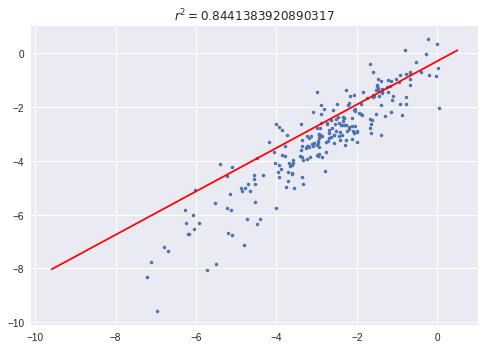

In [15]:
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_true, y_pred)
plt.figure()
plt.plot(y_pred, y_true, '.')
xs = np.linspace(y_true.min(), y_true.max(), 100)
ys = slope * xs + intercept
plt.plot(xs, ys, 'r-')
plt.title('$r^2 = %s$' % np.square(r_value))